# Parsed EDA

## Read feast

In [67]:
import pandas as pd

df = pd.read_json('/Users/apoltavets/anna-apps/annalyticai-jobs/output/4_fact/jobs_fact/2025-11-10_jobs.json', lines=True)
print(df.shape)

(7224, 47)


In [65]:
df.head(2).T

,0,1
job_description_id,126e28fce1c6753c63a04927485bed3b,6fac2b770ef2e015008210da4f98f0e1
job_title,QA Lead,Unknown
experience_level,LEAD,LEAD
required_technical_skills,"[test strategy, test plans, test cases, automa...","[quality engineering, organizational skills, c..."
required_languages,[],[]
required_frameworks,[testing frameworks],[]
required_datastores,[],[]
required_tools,[AWS],[MS Office Applications]
required_cloud,[AWS],[]
job_summary,As a Senior Quality Assurance Engineer - AI/ML...,As a Quality Assurance Engineer at BWX Technol...


In [84]:
df['job_title'] = df.apply(
    lambda row: 'Embedded Engineer' if row['job_title'] == 'Unknown' and row['search'] in ['embedded software engineer', 'embedded systems developer', 'firmware engineer'] else row['job_title'],
    axis=1
)

df['job_title'] = df.apply(
    lambda row: 'Data Engineer' if row['job_title'] == 'Unknown' and row['search'] in ['sql developer'] else
    row['job_title'],
    axis=1
)

In [90]:
df = df[((df['job_title'] != 'Unknown') )]

In [76]:
df.loc[df['job_description_id'] == 'd5b790eeb7ca56f682c1eeaedda30e35', 'job_title'] = 'Software Architect'
df.loc[df['job_description_id'] == 'f11be2d30b4429b9b0ac4ee35398ad98', 'job_title'] = 'Data Engineer'
df.loc[df['job_description_id'] == '2745797af6cf61f1a6cfaaa859e7f887', 'job_title'] = 'Data Engineer'
df.loc[df['job_description_id'] == '21744c3aa9a90799d256df1b1ef62644', 'job_title'] = 'Embedded Engineer'

#############

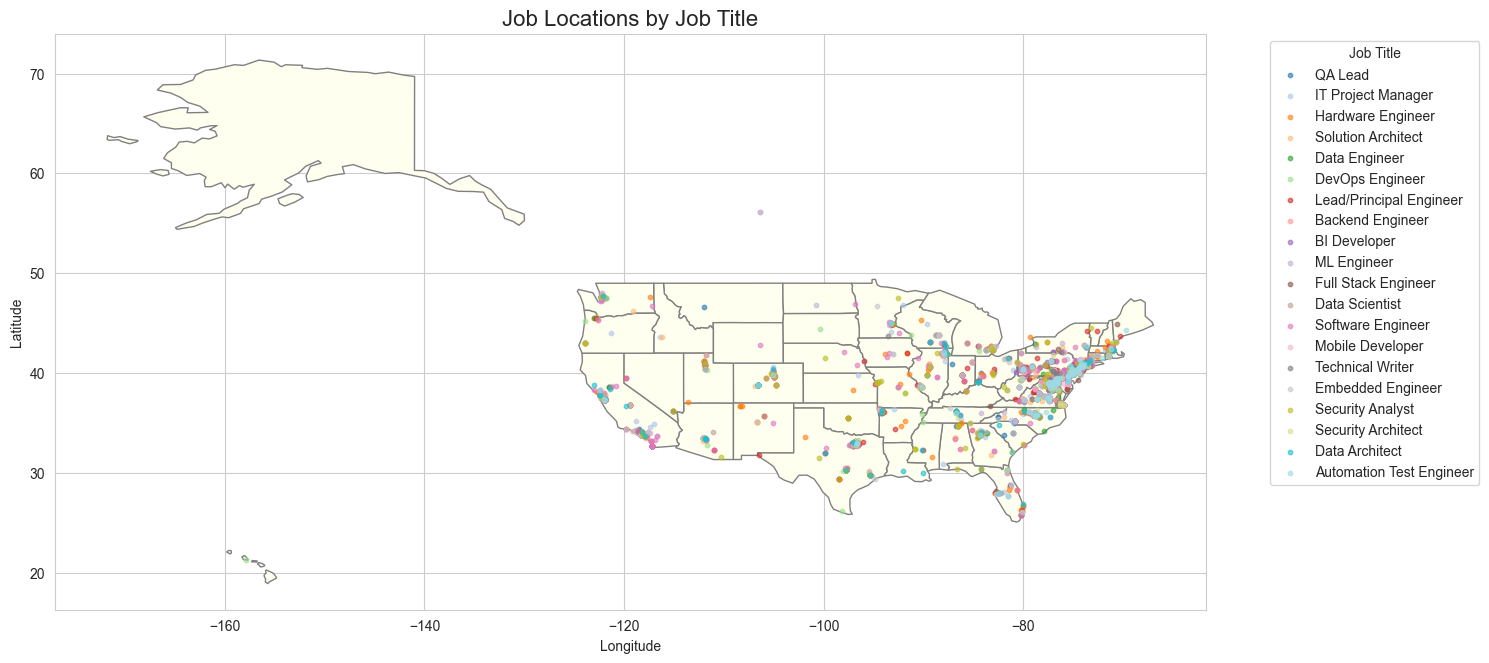

In [91]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

geometry = [Point(xy) for xy in zip(df['job_longitude'], df['job_latitude'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

# Load the world map from the manually downloaded file
world = gpd.read_file('../data/110m_cultural/ne_110m_admin_1_states_provinces.shp')  # Update with the correct path

# Plot the map and the job locations
plt.figure(figsize=(15, 10))
world.plot(ax=plt.gca(), color='ivory', edgecolor='gray')  # Set background 
# Generate a colormap based on the number of unique job titles
unique_titles = geo_df['job_title'].unique()
colors = plt.cm.tab20.colors[:len(unique_titles)]  # Use a colormap with enough distinct colors
color_map = dict(zip(unique_titles, colors))

for title, color in color_map.items():
    subset = geo_df[geo_df['job_title'] == title]
    subset.plot(ax=plt.gca(), markersize=10, color=color, alpha=0.6, label=title)

# Add legend and title
plt.legend(title='Job Title', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Job Locations by Job Title', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

In [92]:
# Group by 'job_state' and 'job_title', count occurrences, and get the top 3 for each state
top_titles_per_state = (
    df.groupby(['job_state', 'job_title'])
    .size()
    .reset_index(name='count')
    .sort_values(['job_state', 'count'], ascending=[True, False])
    .groupby('job_state')
    .head(3)
)

# Display the result
top_titles_per_state

,job_state,job_title,count
9,Alabama,Solution Architect,5
2,Alabama,Hardware Engineer,4
6,Alabama,Security Analyst,4
15,Arizona,Hardware Engineer,7
12,Arizona,DevOps Engineer,4
...,...,...,...
746,Wisconsin,Database Administrator,4
751,Wisconsin,IT Project Manager,4
753,Wisconsin,Penetration Tester,4
759,Wyoming,Penetration Tester,1


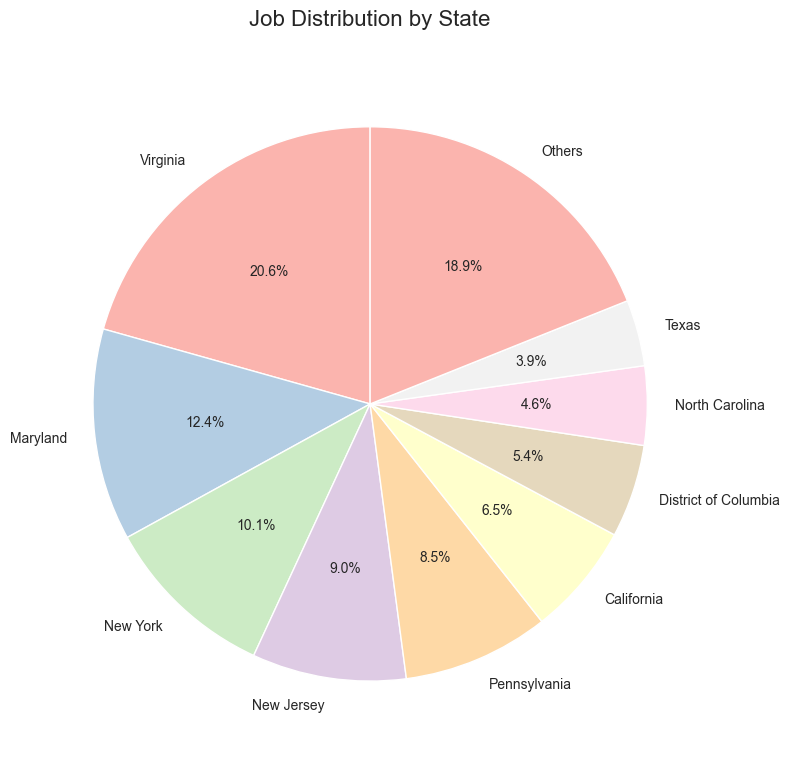

In [93]:
## Job distribution by state
import matplotlib.pyplot as plt

state_agg = df.drop_duplicates(subset='job_id')['job_state'].value_counts().sort_values(ascending=False)
# Get top 10 states and calculate "Others"
top_10_states = state_agg.head(9)
others_sum = state_agg[9:].sum()
state_data = pd.concat([top_10_states, pd.Series({'Others': others_sum})])

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(state_data,
        labels=state_data.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.Pastel1.colors)
plt.title('Job Distribution by State', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()

/var/folders/x8/ps_xddr95734lgrb6gqpr7g80000gp/T/ipykernel_9549/3055155498.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=experience_df, x='experience_level', y='count', palette='viridis')


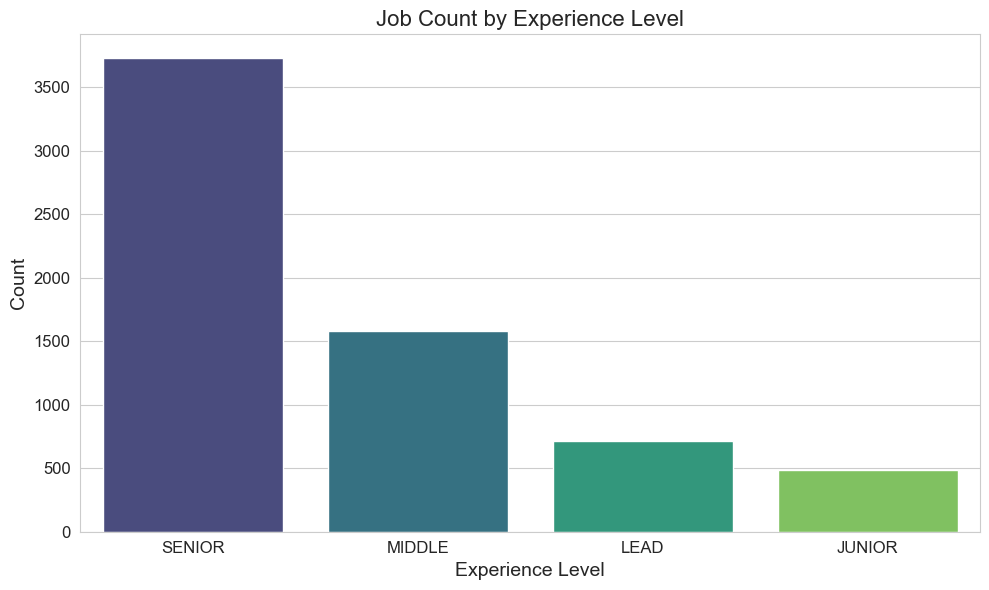

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count occurrences of each experience level
experience_counts = df['experience_level'].value_counts()

# Convert to DataFrame for Seaborn
experience_df = experience_counts.reset_index()
experience_df.columns = ['experience_level', 'count']

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=experience_df, x='experience_level', y='count', palette='viridis')

# Add labels and title
plt.title('Job Count by Experience Level', fontsize=16)
plt.xlabel('Experience Level', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [95]:
l = df[['job_id', 'required_languages']].explode('required_languages')['required_languages'].value_counts().reset_index().sort_values(by='count', ascending=False).head(15)

/var/folders/x8/ps_xddr95734lgrb6gqpr7g80000gp/T/ipykernel_9549/2429884088.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=l, x='count', y='required_languages', palette='viridis')


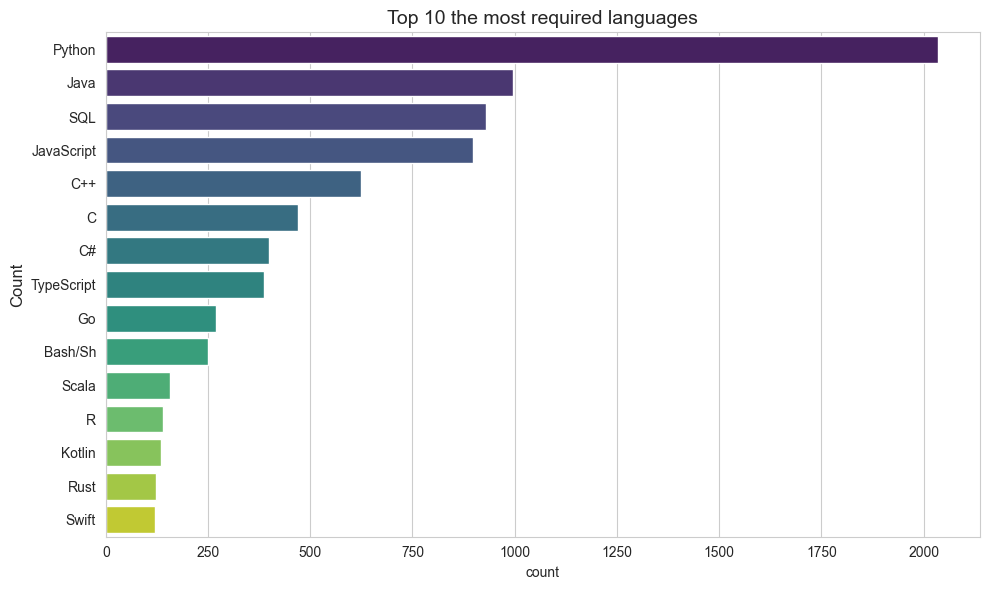

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=l, x='count', y='required_languages', palette='viridis')

# Add labels and title
plt.title('Top 10 the most required languages', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

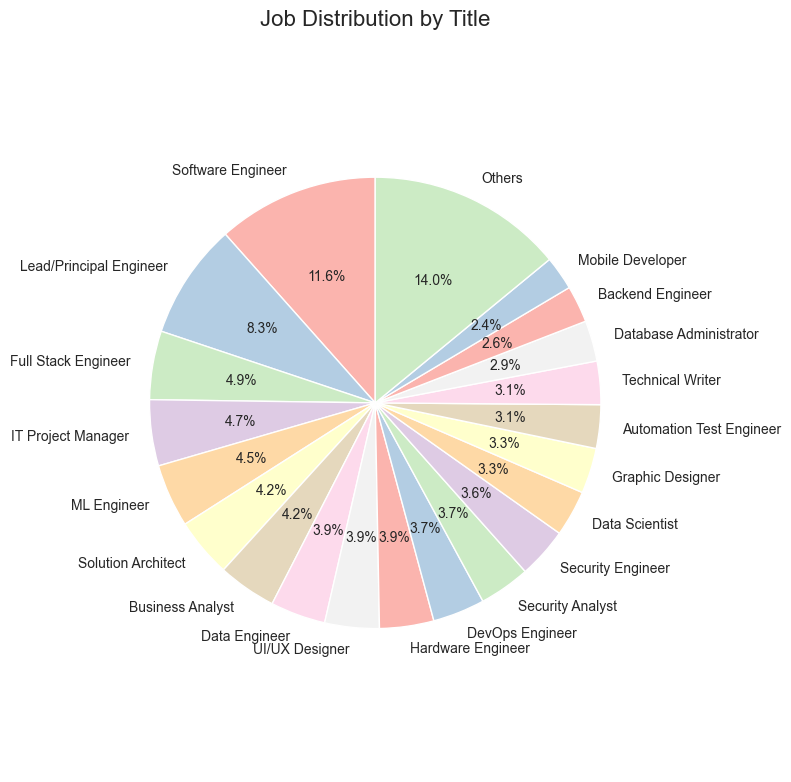

In [97]:
## Job distribution by state
import matplotlib.pyplot as plt

state_agg = df.drop_duplicates(subset='job_id')['job_title'].value_counts().sort_values(ascending=False)
# Get top 10 states and calculate "Others"
top_10_states = state_agg.head(20)
others_sum = state_agg[20:].sum()
state_data = pd.concat([top_10_states, pd.Series({'Others': others_sum})])

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(state_data,
        labels=state_data.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.Pastel1.colors)
plt.title('Job Distribution by Title', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [62]:
df.head(3).T

,0,1,2
job_description_id,50e49b84eea8805d5988652078d85120,4179aa4d1c660453d5c13024a67625e6,63bf7ff740d218f641c2d59d0559ceb8
job_title,Product Manager,Software Engineer,Full Stack Engineer
experience_level,SENIOR,SENIOR,MIDDLE
required_technical_skills,"[AI and Machine learning, Data analysis, Chatb...","[object-oriented analysis, design, programming...","[Web Development, Database experience, Deploym..."
required_languages,[],"[C++, Python]","[C#, Java]"
required_frameworks,[],"[RTOS (QNX, VxWorks), Agile]","[ASP.Net Web Forms, ASP.Net MVC]"
required_datastores,[],[],[MongoDB]
required_tools,[],[],[]
required_cloud,[],[],[]
job_summary,Seeking a leader for the Digital Client Suppor...,"As a Senior Embedded Software Developer, you w...","As a Full Stack Engineer at GDIT, you will des..."


In [101]:
df.explode('required_frameworks')['required_frameworks'].value_counts()

required_frameworks
React                       290
Angular                     232
PyTorch                     201
TensorFlow                  165
Terraform                   136
                           ... 
Azure Services                1
enterprise QA frameworks      1
Burp Suite Pro                1
Scapy                         1
Apache Hive                   1
Name: count, Length: 1490, dtype: int64

In [103]:
df['job_title'].unique()

array(['QA Lead', 'IT Project Manager', 'Hardware Engineer',
       'Solution Architect', 'Data Engineer', 'DevOps Engineer',
       'Lead/Principal Engineer', 'Backend Engineer', 'BI Developer',
       'ML Engineer', 'Full Stack Engineer', 'Data Scientist',
       'Software Engineer', 'Mobile Developer', 'Technical Writer',
       'Embedded Engineer', 'Security Analyst', 'Security Architect',
       'Data Architect', 'Automation Test Engineer', 'UI/UX Designer',
       'Manual Tester', 'Business Analyst', 'Computer Vision Engineer',
       'Graphic Designer', 'Robotics Engineer', 'Game Developer',
       'Security Engineer', 'Database Administrator', 'Frontend Engineer',
       'Prompt Engineer', 'Software Architect', 'Product Manager',
       'Penetration Tester', 'Blockchain Developer', 'System Designer'],
      dtype=object)

In [105]:
df[df['job_title'].isin(['Data Engineer', 'Data Scientist', 'Data Architect', 'DevOps Engineer', 'Lead/Principal Engineer', 'ML Engineer', 'Software Architect', 'Software Engineer'])]['required_frameworks'].explode().value_counts()

required_frameworks
PyTorch                            170
TensorFlow                         140
Terraform                          113
Kubernetes                          93
React                               89
                                  ... 
Apache Beam                          1
Scio                                 1
AWS Cloud Development Kit (CDK)      1
R                                    1
JEE                                  1
Name: count, Length: 826, dtype: int64